# Geometric transforms in OpenGL
## Model, view and projection matrices
How does your software (e.g., video game) go from a model of a 3d world to what you see on the screen? A key aspect of this rendering pipeline is the set of geometric transformations implemented by the model, view, and projection matrices. I won't explain them in detail here, but *demonstrate* them. This code is meant to help sharpen your intuitions by working through a very simple example without needing any OpenGL but just simple matplotlib. The  code is best if run in an environment where you can *interact* with the 3D plots: rotate, inspect, and destroy them.

For really good overviews of the geometric pipeline, see:
- [OpenGL Coordinate System Transforms](https://learnopengl.com/Getting-started/Coordinate-Systems)
- [Computing 2d coordinates of 3d points](https://unspecified.wordpress.com/2012/06/21/calculating-the-gluperspective-matrix-and-other-opengl-matrix-maths/)

For an intro to the standard TSR (translate, scale, rotate) transforms in homogeneous coordinates, see the first three parts of this excellent tutorial:
- [Geometric Transforms](http://in2gpu.com/2015/04/15/geometric-transformations/)


### Set up environment

In [39]:
import numpy as np
import matplotlib.pyplot as plt #plt.plot(x, y)
import matplotlib as mpl
from mpl_toolkits.mplot3d.art3d import Poly3DCollection #, Line3DCollection
plt.style.use('classic')
#The following should let you interact with plots but is not strictly necessary
%matplotlib notebook  

### Create the 3d graphical object and its helper functions
The main class here is `GraphObject3D`: it contains all the vertices (called `points`), and methods for doing the standard transforms (scale, translate, rotate), plotting the object, and its projection to the x-y plane. Frankly you can skip this code for now it's just for creating and displaying objects. I will discuss how they are transformed below, which is more the point.

In [40]:
class GraphObject3D:
    """ 
    Generic 3d graphical object to be used for plotting and applying
    TRS operations (translate, rotate, scale). Created to illustrated model and
    view transforms in OpenGL context.
    """
    def __init__(self, points, face_inds, position=np.array([0, 0, 0])):
        self.points = points;
        self.face_inds = face_inds
        #Object starts at position 0, and is translated to given position
        self.initial_position = position
        self.translate(position)
           
    def scale(self, scale_factor):
        scale_mat = np.array([[scale_factor, 0,            0,              0],
                              [0,            scale_factor, 0,              0],
                              [0,            0,            scale_factor,   0],
                              [0,            0,            0,              1]]);
        self.points = scale_mat.dot(self.points)
        
    def translate(self, translate_value):
        translation_mat = np.array([[1,  0,  0, translate_value[0]],
                                    [0,  1,  0, translate_value[1]],
                                    [0,  0,  1, translate_value[2]],
                                    [0,  0,  0,                 1]]);
        self.points = translation_mat.dot(self.points)
        
    def xrotate(self, theta):
        xrotation_mat = np.array([
                          [   1,     0,              0,         0,],
                          [   0, np.cos(theta),  -np.sin(theta), 0,],
                          [   0, np.sin(theta),  np.cos(theta), 0,],
                          [   0,      0,              0,        1,]
                        ])
        self.points = xrotation_mat.dot(self.points)
        
    def yrotate(self, theta):
        yrotation_mat = np.array([
                          [   np.cos(theta),    0,  np.sin(theta),  0,],
                          [   0,                1,    0,            0,],
                          [  -np.sin(theta),    0,  np.cos(theta),  0,],
                         [   0,                0,        0,        1,]
                        ])
        self.points = yrotation_mat.dot(self.points)  
        
    def zrotate(self, theta):
        zrotation_mat = np.array([
                          [ np.cos(theta),  -np.sin(theta), 0, 0,],
                          [ np.sin(theta),   np.cos(theta), 0, 0,],
                          [   0,      0,              1,        0,],
                          [   0,      0,              0,        1,],                       
                        ])
        self.points = zrotation_mat.dot(self.points) 
                                       
    def transform(self, transform_matrix):
        """
        If you want to feed an arbitrary transform.
        """
        self.points = transform_matrix.dot(self.points)
        
    @property
    def xcart(self):
        return self.points[0,:]/self.w
        
    @property
    def ycart(self):
        return self.points[1,:]/self.w
    
    @property
    def zcart(self):
        return self.points[2,:]/self.w
    
    @property
    def w(self):
        return self.points[3,:]
   
    @property 
    def faces(self):
        """
        What points are connected together as faces to plot
        Note division by w is because we are in homogeneous coordinates.
        """
        num_faces = self.face_inds.shape[0]
        faces = []
        for face_num in range(num_faces):
            faces.append([np.array(self.points[0:3, i]/self.w[i]) for i in self.face_inds[face_num]])
        return np.array(faces)
        
        
    def plot(self, axes = None, edgecolor = 'b', facecolor = 'cyan'):
        """
        Plots the object in 3d space
        """
        if axes == None:
            fig = plt.figure()
            axes = fig.add_subplot(111, projection='3d')
        #Plot vertices
        axes.scatter3D(self.xcart, self.ycart, self.zcart, color = edgecolor)
        #Plot edges and faces
        collection = Poly3DCollection(self.faces, linewidths = 1, alpha = 0.25)
        collection.set_facecolor(facecolor)
        collection.set_edgecolor(edgecolor)
        axes.add_collection3d(collection)
        axes.set_aspect('equal')
        set_axes_equal(axes)  #from stack overflow
        return axes
    
    def plot_projection(self, axes = None, color = 'b'):
        """
        Plots the projection to the xy plane, and draws
        the device-normalized coordinate frame for reference (square 
        from -1 to 1).
        """
        if axes == None:
            fig, axes = plt.subplots()
        axes.scatter(self.xcart, self.ycart, color = color)
        #plot x-y projection of each face in 2d
        for face in self.faces:
            xvals = [arr[0] for arr in face]
            xvals.append(xvals[0])
            yvals = [arr[1] for arr in face]      
            yvals.append(yvals[0])
            axes.plot(xvals, yvals, color = color)
            
        viewport = np.array([[1, -1, -1, 1, 1],
                             [1, 1, -1, -1, 1]]) 
        axes.plot(viewport[0,:], viewport[1,:], color = 'k')
        axes.set_xlabel('x')
        axes.set_ylabel('y')
        axes.grid(color = (.8, .8, .8), linestyle = 'solid')
        axes.axis('tight')
        axes.set_aspect('equal')
        return axes
    

def centroid(points):
    """ For when you want to plot the center of an object.
    I should probably just make this a method, but oh well."""
    x_center = np.mean(points[0,:])
    y_center = np.mean(points[1,:])
    z_center = np.mean(points[2,:])
    return np.array([x_center, y_center, z_center])


def set_axes_radius(ax, origin, radius):
    '''
    Helper function for set_axes_equal.
    From https://stackoverflow.com/a/50664367/1886357
    '''
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])

def set_axes_equal(ax):
    '''
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.
    From https://stackoverflow.com/a/50664367/1886357
      
    Usage:
         ax.set_aspect('equal')
         set_axes_equal(ax)
    '''

    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])

    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    set_axes_radius(ax, origin, radius)

### Populate the world with a couple of objects
We will create a camera object and a couple of cubes to visualize in our world.
#### Create a camera object  

In [41]:
camera_target = np.array([1/np.sqrt(2), 1, 1/np.sqrt(2),])
xvals = [-camera_target[0]/2, camera_target[0]]
yvals = [-camera_target[1]/2, camera_target[1]]
zvals = [-camera_target[2]/2, camera_target[2]]


cam_width = 1;
cam_height = cam_width/np.sqrt(2);
cam_coord = cam_width/2;
cam_points = np.array([
        [-cam_coord,  cam_coord,   cam_coord, -cam_coord,    0,],      
        [ cam_coord,  cam_coord,  -cam_coord, -cam_coord,    0,],
        [ cam_height, cam_height,  cam_height, cam_height,  0],
        [ 1.,  1,  1,  1, 1,] ]);
    
# generate list of sides' polygons of our camera (four sides then base)
cam_face_inds = np.array([
        [0, 1, 4],
        [0, 3, 4],
        [2, 1, 4],
        [2, 3, 4],
        [0, 1, 2, 3]]);
#Create camera instance
camera = GraphObject3D(cam_points, cam_face_inds)

#### Rotate the camera and place it in the world 
This is what the model matrix does. Here we are rotating it, translating it. We could create a single model matrix by multiplying the rotation and translation transforms together, and that would be the model matrix `M`. But frankly, those unfactored model matrices are hard to interpret, so I'm leaving the factors separate and explicit so you can  tinker with the way the camera is embedded in the world. If you want to feed an arbitrary model matrix you can do so, and apply it using `camera.tranform(M)`.

In [42]:
#orient camera
camera.xrotate(-np.pi/4)
camera.yrotate(np.pi/4)

# put camera in world
cam_initial_position = -1.5*np.array(camera_target);
camera.translate(cam_initial_position);

#### Plot the camera
Just for fun, let's take a look at the camera.

<IPython.core.display.Javascript object>


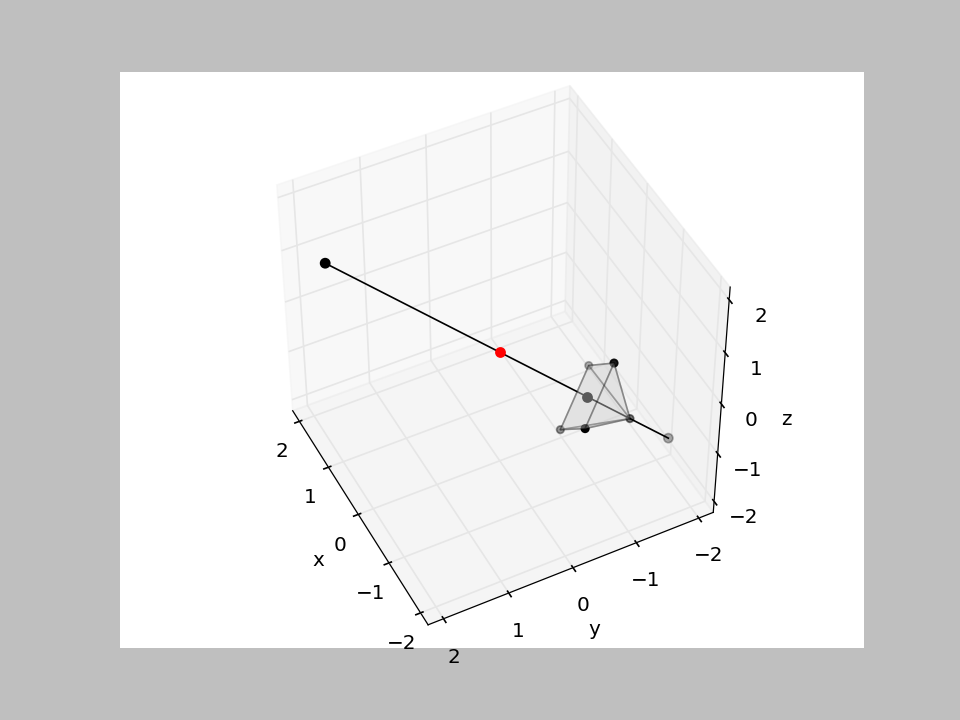

In [44]:
ax_world = camera.plot(facecolor = (.8, .8, .8), edgecolor = 'k')
scale_factor = 1.3;
scatter_size = 30
#Plot the line along which the camera points
xvals_new = scale_factor*np.array([cam_initial_position[0], -cam_initial_position[0]])
yvals_new = scale_factor*np.array([cam_initial_position[1], -cam_initial_position[1]])
zvals_new = scale_factor*np.array([cam_initial_position[2], -cam_initial_position[2]])
ax_world.plot(xvals_new, yvals_new, zvals_new, color = 'k', linewidth = 1)
ax_world.scatter3D(xvals_new, yvals_new, zvals_new, s = scatter_size, color = 'k')
#plot centroid
cam_shifted_centroid = centroid(camera.points[0:3, 0:4])
ax_world.scatter3D(cam_shifted_centroid[0], cam_shifted_centroid[1], cam_shifted_centroid[2], 
                   s = scatter_size, color = 'k')
ax_world.scatter3D(0, 0, 0, s = scatter_size, color = 'r')
ax_world.view_init(elev=46, azim=153)
ax_world.set_xlabel('x')
ax_world.set_ylabel('y')
ax_world.set_zlabel('z')
ax_world.axis('tight')
ax_world.set_aspect('equal')
set_axes_equal(ax_world) 

#### Create generic cube to populate the world
We have a camera. Technically it's not part of the world, but something that simply *views* the world. Let's create a cube object so we can put some stuff in our world. 

In [45]:
cube_points = np.array([
                [-1,  1,  1, -1, -1,  1, 1, -1,],
                [-1, -1,  1,  1, -1, -1, 1,  1,],
                [-1, -1, -1, -1,  1,  1, 1,  1, ], 
                 [1,  1,  1,  1,  1,  1, 1,  1, ]]);

cube_face_inds = np.array([
        [0, 1, 2, 3,],
        [4, 5, 6, 7,],
        [0, 1, 5, 4,],
        [2, 3, 7, 6,],
        [1, 2, 6, 5,],
        [4, 7, 3, 0]
        ])    

#### Create cube 1, rotate it, and place it in world
Again, this is basically taking care of the operations of the model matrix.

In [46]:
cube1_initial_position = -1.5*cam_initial_position
cube1 = GraphObject3D(cube_points, cube_face_inds)
cube1.scale(.8)
cube1.xrotate(np.pi/6)
cube1.yrotate(np.pi/4)
cube1.translate(cube1_initial_position)

#### Do same for a second cube
You'll see this cube we are putting outside the view of the camera.

In [47]:
cube2_initial_position = -2*cam_initial_position
cube2 = GraphObject3D(cube_points, cube_face_inds)
cube2.scale(.5)
cube2.xrotate(np.pi/6)
cube2.yrotate(np.pi/4)
cube2.translate(cube2_initial_position)
cube2.zrotate(-np.pi/1.5)

#### Plot the cubes with the camera
Note that the camera is pointing right at cube1 (green) while cube1 (red) is sort of off to the side and will likely be left outside of the FOV in the final projection.

<IPython.core.display.Javascript object>


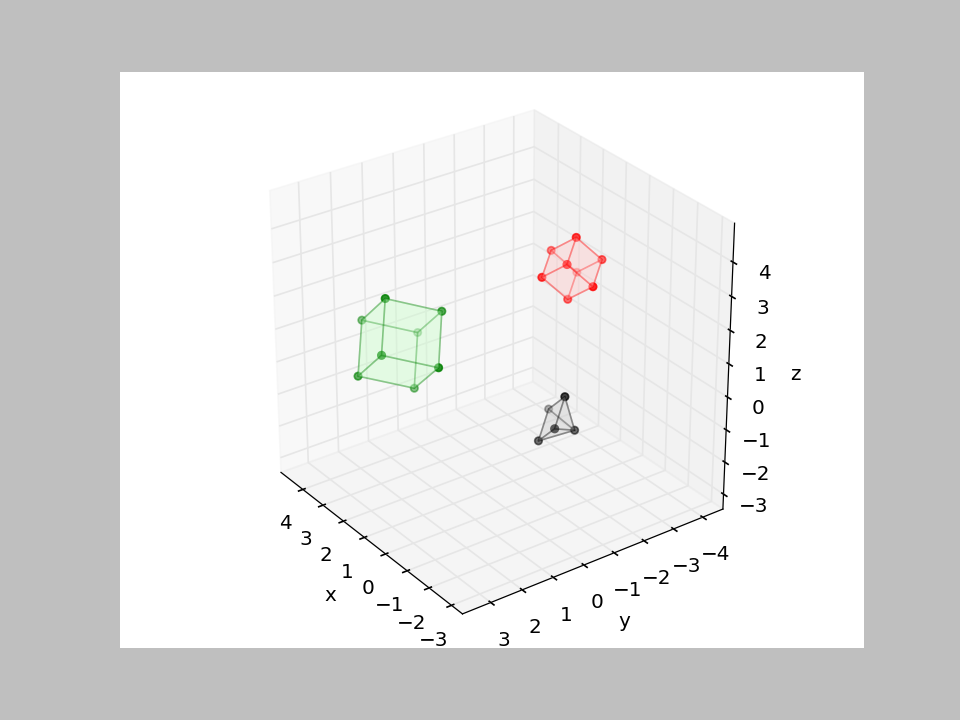

In [50]:
ax_world = camera.plot(facecolor = (.8, .8, .8), edgecolor = 'k')
cube1.plot(axes = ax_world, facecolor = (.8, 1, 0.8), edgecolor = 'g')
cube2.plot(axes = ax_world, facecolor = (1.0, 0.8, 0.8), edgecolor = 'r')
ax_world.set_xlabel('x')
ax_world.set_ylabel('y')
ax_world.set_zlabel('z')
ax_world.view_init(elev=29, azim=144)
ax_world.axis('tight')
ax_world.set_aspect('equal')
set_axes_equal(ax_world) 

### Apply the view matrix
You've got a world with stuff, and there is a camera in it, but nowe we want to determine how 
it will *look* to the camera. The first thing to do is transform everything in the world to a 
camera-based coordinate system. This involves first translating so that 
the camera is at the origin, and then rotating the world so that it aligns with the 
*camera's* main axes.         

There are some good discussions of this online. For instance:
- [World, view, and projection transformation matrix](http://www.codinglabs.net/article_world_view_projection_matrix.aspx) (Conceptual)
- [Constructing the viewing matrix](http://www.songho.ca/opengl/gl_camera.html#lookat) (Mathematical)

#### Translate with Vt 
First shift the world so that the camera is at zero.

In [51]:
trans_mag = -cam_initial_position;
Vt = np.array([
        [1, 0, 0, trans_mag[0],],
        [0, 1, 0, trans_mag[1],],
        [0, 0, 1, trans_mag[2],],
        [0, 0, 0, 1]]);
camera.transform(Vt)
cube1.transform(Vt)
cube2.transform(Vt)

#### Rotate with Vr
While the camera is at the origin now (you can plot it if you want with `camera.plot()`, the world needs to be represented relative to the camera. Mathematically, this is a change of basis from the world- to camera-based coordinate system. One reason for contructing these orthonormal basis sets is because when you put them in a
matrix, the inverse can be calculated simply by taking the transpose.

In [52]:
target = -camera_target/np.linalg.norm(camera_target); #p-e/norm(p-e) p is zero
up_raw = np.array([-np.sqrt(2), 0., np.sqrt(2)])
up = up_raw/np.linalg.norm(up_raw)
side_raw = np.cross(up, target)  #-forward b/c convention is forward is from object to camera
side = side_raw/np.linalg.norm(side_raw)
# Construct Vr and apply
Vr = np.array([
                [side[0],     side[1],  side[2],  0,],
                [up[0],          up[1],   up[2],  0,],
                [target[0], target[1], target[2], 0],
                [0, 0, 0, 1,]
              ])
camera.transform(Vr)
cube1.transform(Vr)
cube2.transform(Vr)

#### Plot the world in the new coordinate system
The world is now in a right-handed coordinate system centered on the camera that is facing in the *negative* z direction. This is simply the convention in OpenGL. There is lots of discussion online about why this is the case, but none of it is convincing: it's just the convention and it didn't have to be that way. Let's take a look.

<IPython.core.display.Javascript object>


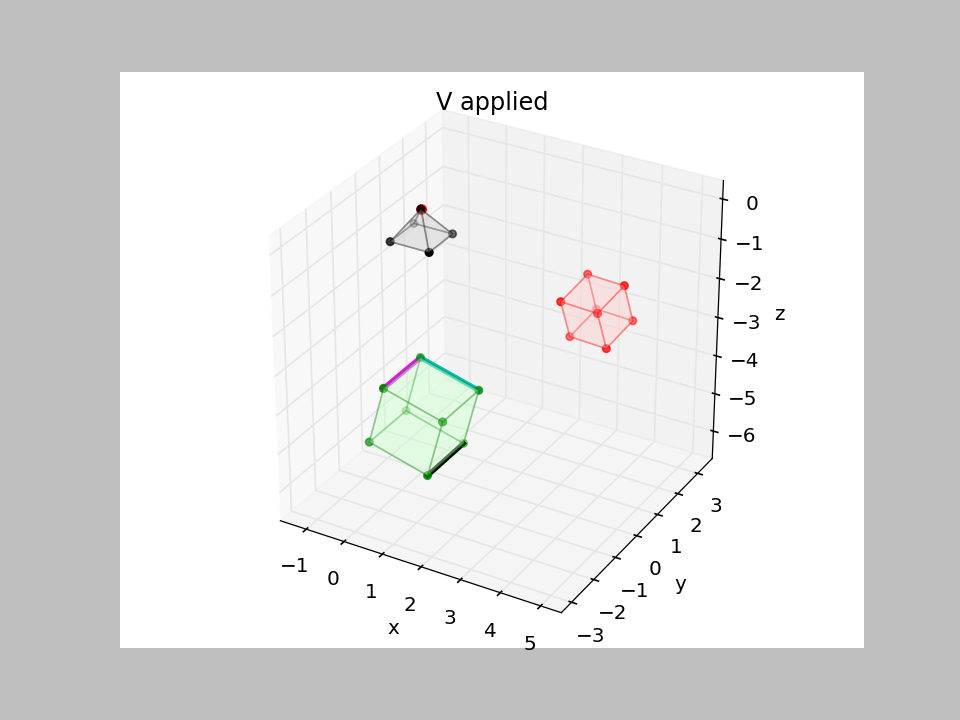

In [53]:
scatter_size = 30;
cam_centroid = centroid(camera.points[0:3, 0:4])

ax3 = camera.plot(edgecolor = 'k', facecolor = (.8, .8, .8))
cube1.plot(axes = ax3, edgecolor = 'g', facecolor = (.8, 1, .8))
cube2.plot(axes = ax3, edgecolor = 'r', facecolor = (1, .8, .8))      
ax3.scatter3D(0, 0, 0, s = scatter_size, color = 'r')
#Plot three benchmark edges that we will use to look at projections later
lf_inds = [0, 1]  #left front
rb_inds = [6, 7]  #right back
tf_inds = [0, 4] #top front
ax3.plot([cube1.xcart[lf_inds[0]], cube1.xcart[lf_inds[1]]],
         [cube1.ycart[lf_inds[0]], cube1.ycart[lf_inds[1]]],
         [cube1.zcart[lf_inds[0]], cube1.zcart[lf_inds[1]]], color = (1, 0, 1), linewidth = 3)
ax3.plot([cube1.xcart[rb_inds[0]], cube1.xcart[rb_inds[1]]],
         [cube1.ycart[rb_inds[0]], cube1.ycart[rb_inds[1]]],
         [cube1.zcart[rb_inds[0]], cube1.zcart[rb_inds[1]]], color = 'k', linewidth = 3)
ax3.plot([cube1.xcart[tf_inds[0]], cube1.xcart[tf_inds[1]]],
         [cube1.ycart[tf_inds[0]], cube1.ycart[tf_inds[1]]],
         [cube1.zcart[tf_inds[0]], cube1.zcart[tf_inds[1]]], color = 'c', linewidth = 3)
plt.title('V applied')  
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
ax3.axis('tight')
ax3.set_aspect('equal')
set_axes_equal(ax3)  

### The projection matrix
Now that the camera is at the origin and facing `-z`, we must calculate what is projected to the camera's image plane. There are many derivations of the formula for the projection matrix, and some of them are different: the main thing is make sure your values satisfy certain constraints (see below). Here is one nice derivation:
[Projection Matrix](http://www.songho.ca/opengl/gl_projectionmatrix.html#perspective). Note in what follows we are only going to examine cube1, and cube2 is left as an exercise. :) Note we are working with a perspective, not orthographic, projection here (i.e., things further away look smaller).
 

#### Create the projection matrix and apply it to cube1

In [54]:
proj_mat = np.zeros((4,4));
fov_angle = np.pi/3; 
angle_tan = np.tan(fov_angle/2);  
width = 4;
height = 3;
aspect_ratio = width/height;
far_z = 10;
near_z = 1;

proj_mat[0, 0] = 1/(angle_tan*aspect_ratio);
proj_mat[1,1] = 1/angle_tan;
proj_mat[2,2] = (near_z+far_z)/(near_z - far_z)
proj_mat[2,3] = (2*near_z*far_z)/(near_z - far_z)
proj_mat[3,2] = -1;

cube1.transform(proj_mat)

#### Plot how the vectors pointing along the (negative) z axis will behave vs z
When `z=-near_z`, it should project to -1, and at `z=-far_z`, it should project to +1. This is a great
way to troubleshoot your code: this is a minimal sanity check for your projection matrix (caveat: some projection matrices have different limits, and go from 0 to 1, but let's ignore them).

<IPython.core.display.Javascript object>


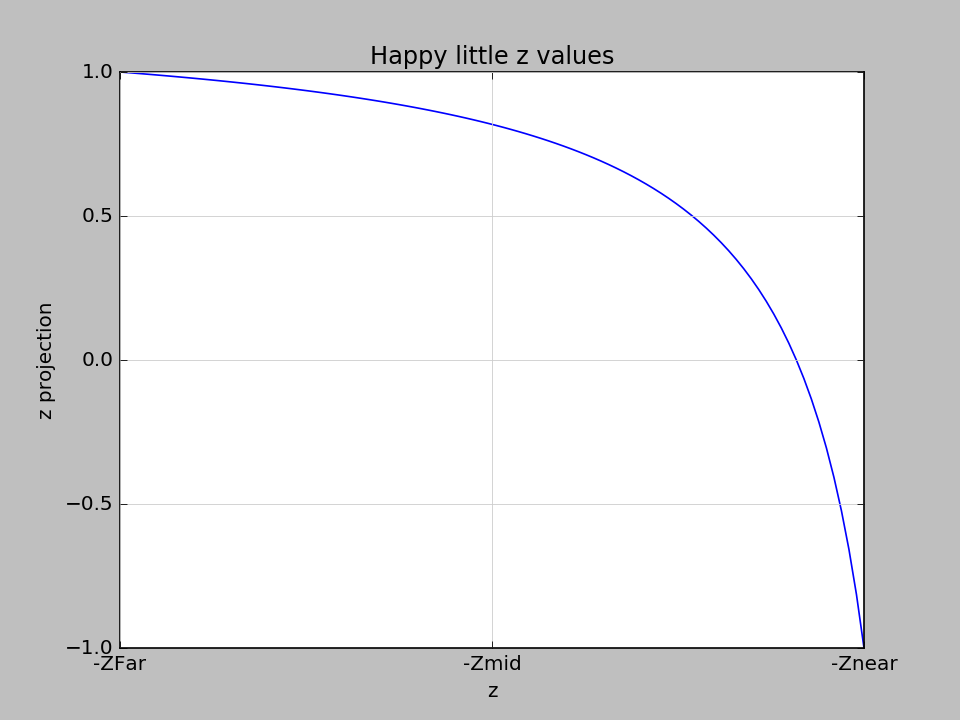

Text(0.5, 1.0, 'Happy little z values')

In [55]:
zvals = np.linspace(-near_z, -far_z, num = 100)
proj_values = []
for z in zvals:
    full_projection = proj_mat.dot(np.array([0,0,z,1]))
    zprojection = full_projection[2]/full_projection[3]
    proj_values.append(zprojection)
fig, axz = plt.subplots()
axz.plot(zvals, proj_values)
axz.set_xlabel('z')
axz.set_ylabel('z projection')
axz.set_xticks([-far_z, -far_z+(far_z - near_z)/2, -near_z])
axz.set_xticklabels(['-ZFar', '-Zmid', '-Znear'])
axz.grid(color = (.8, .8, .8), linestyle = 'solid')
axz.axis('tight')
axz.set_title('Happy little z values')

#### Project cube1 onto x-y 
Anything outside of the `[-1, 1]` square is outside of the camera's NDC (normalized device coordinates) and will not be rendered. As we expected, cube1 is squarely in the camera's view. Also note we finally see the reason that I've plotted the left, top, and right edges: we now see that they are maintained exactly where they should be in the projection. This may sound trivial, but it is easy to make a math error that breaks this, so it is useful to have a visual debugger built in.

<IPython.core.display.Javascript object>


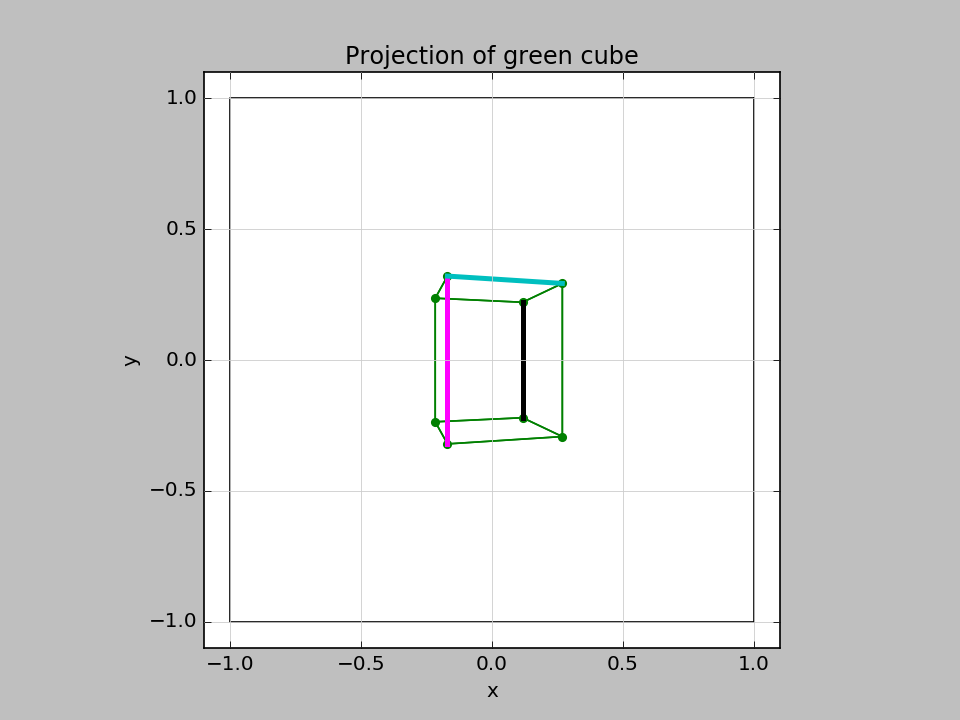

Text(0.5, 1.0, 'Projection of green cube')

In [57]:
ax = cube1.plot_projection(color = 'g') 
ax.plot([cube1.xcart[lf_inds[0]], cube1.xcart[lf_inds[1]]],
         [cube1.ycart[lf_inds[0]], cube1.ycart[lf_inds[1]]], color = (1, 0, 1), linewidth = 3)
ax.plot([cube1.xcart[rb_inds[0]], cube1.xcart[rb_inds[1]]],
         [cube1.ycart[rb_inds[0]], cube1.ycart[rb_inds[1]]], color = 'k', linewidth = 3)
ax.plot([cube1.xcart[tf_inds[0]], cube1.xcart[tf_inds[1]]],
         [cube1.ycart[tf_inds[0]], cube1.ycart[tf_inds[1]]], color = 'c', linewidth = 3)
ax.set_title('Projection of green cube')

#### Look at cube in 3d after application of projection matrix
But what about on the z axis? The same thing holds as for x-y. If something doesn't fall within
`[-z_near, -z_far]`, it will not be rendered because it will fall outside `z=[-1, 1]`, the NDC. Note that our green cube falls well within the NDC in z.

<IPython.core.display.Javascript object>


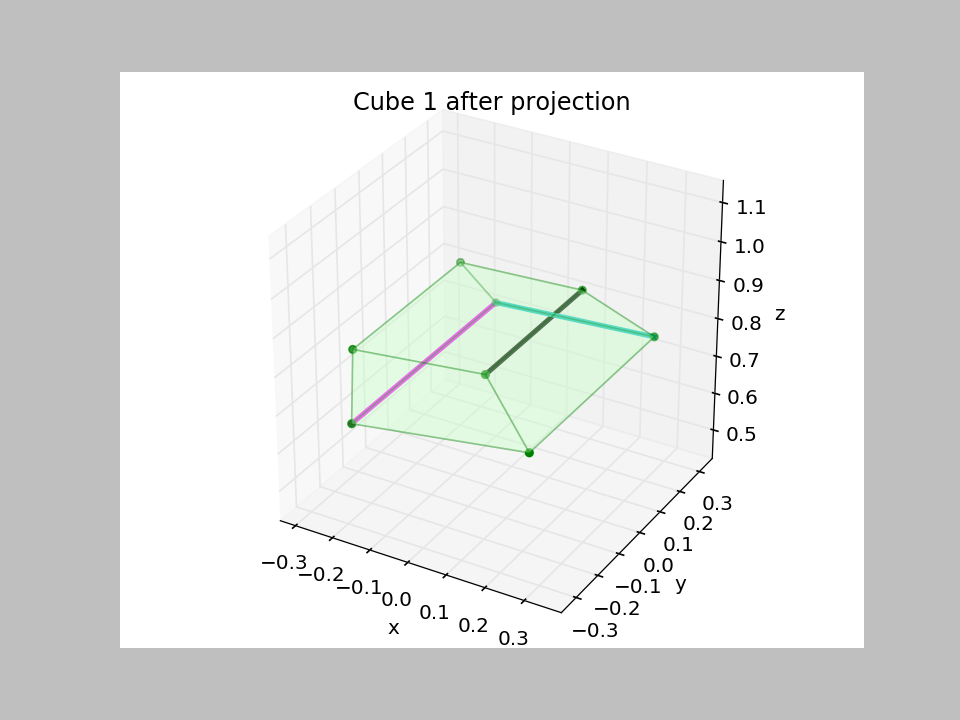

In [58]:
axp1 = cube1.plot(facecolor = (.8, 1, .8), edgecolor = 'g')
axp1.set_title("Cube 1 after projection")
axp1.plot([cube1.xcart[lf_inds[0]], cube1.xcart[lf_inds[1]]],
         [cube1.ycart[lf_inds[0]], cube1.ycart[lf_inds[1]]],
         [cube1.zcart[lf_inds[0]], cube1.zcart[lf_inds[1]]], color = (1, 0, 1), linewidth = 3)
axp1.plot([cube1.xcart[rb_inds[0]], cube1.xcart[rb_inds[1]]],
         [cube1.ycart[rb_inds[0]], cube1.ycart[rb_inds[1]]],
         [cube1.zcart[rb_inds[0]], cube1.zcart[rb_inds[1]]], color = 'k', linewidth = 3)
axp1.plot([cube1.xcart[tf_inds[0]], cube1.xcart[tf_inds[1]]],
         [cube1.ycart[tf_inds[0]], cube1.ycart[tf_inds[1]]],
         [cube1.zcart[tf_inds[0]], cube1.zcart[tf_inds[1]]], color = 'c', linewidth = 3)
axp1.set_xlabel('x')
axp1.set_ylabel('y')
axp1.set_zlabel('z')
axp1.axis('tight')
axp1.set_aspect('equal')
set_axes_equal(axp1)  

Note that the object appears all distorted now. After ther vertices are squeezed through
the projection matrix, the projective geometric properties that we care about (i.e., the x-y
projections) are preserved, but the 3D properties are fubar. This is the ultimate fate of our
cube as it is pre-processed and sent off to be rendered on a screen. 

## Have fun
We have moved our objects to the correct locations in the world (model matrix), transformed the world into a camera-based coordinate system (view matrix), and then used a perspectival projection matrix to show what this world would look like from the perspective of the camera. There is a lot I have left out of this example, but hopefully with the code you will be able to play with it and break it yourself. E.g., try going through the projection steps with cube2 and see what happens. Change the position of cube1 and see how its appearance changes. There is a lot you can do with this simple little toy example.